<a href="https://colab.research.google.com/github/ICSM/pgmuvi/blob/main/pgmuvi_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use pgmuvi - a brief introduction



`pgmuvi` is a package to infer the multiwavelength behaviour of astronomical lightcurves using Gaussian Processes. It uses the `torch` and `gpytorch` libraries to define GP models, and the probabilistic programming language `pyro` to perform optimisation and sampling of the parameter space.

## Why pgmuvi

Many packages exist to interpret lightcurves with GPs, so why do we need another one? `pgmuvi` builds on the latest highly-optimised libraries which allow inference with arbitrary GP kernels. This makes it feasible to implement models that are very general, which is important in astronomy where lightcurves can have a wide range of different properties. However, this normally results in a speed penalty, since naive GPs scale with $\mathcal{O}\left(n^3\right)$; to combat this, the libraries implement scalable approaches to GP inference, such as GPU computing. This allows both a wide range of GP kernels and fast inference, meaning that `pgmuvi` can be applied to arbitrary astronomical lightcurves without taking _that much_ longer than codes which are restricted to special cases but blisteringly fast in those cases.

## What does pgmuvi do

The objective is to understand what the PSD of the variability is, and in the case of (quasi-)periodic variables determine their dominant periods. To do this, `pgmuvi` uses a `SpectralMixtureKernel`, which models the PSD of the covariances of the GP as a Gaussian Mixture model. This is a very flexible model which is able to represent a wide range of different kinds of behaviour, so can be useful for a wide range of astronomical lightcurves.

## How to use pgmuvi

The rest of this notebook is basically a quickstart guide to `pgmuvi`. It generates sythetic observations, but you can replace these with reading in your own data and passing it to `pgmuvi`'s `Lightcurve` classes to apply it to your own data.

In [1]:
try: #This won't work right now - instead clone the repository and `pip install -e .`
    import pgmuvi
except ImportError:
    %pip install git+https://github.com/ICSM/pgmuvi.git
    import pgmuvi

c:\Users\peter\anaconda3\envs\pgmuvi_dev\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we have imported/installed pgmuvi, we can use it to fit some data. For the purposes of this tutorial, we will generate two synthetic datasets - a single-wavelength lightcurve with very simple behaviour, and a second multi-wavelength one with some more complex patterns in it. It is important to note that the data must be in the form of `torch` tensors, rather than numpy arrays or other data types.

In [2]:
import torch
import gpytorch
import numpy as np
""" Let's generate some synthetic data from a perturbed sine curve
    but on the same time sampling as the real data"""

P = np.random.uniform(30, 300)#137. #Days!
print("True period: ",P," days")
n_data = 400
jd_min = 2450000
n_periods = np.random.uniform(3,10)
jd_max = jd_min + P*(n_periods)
print("Simulating for ",n_periods," periods")

#train_mag =
#train_mag = train_mag + 0.1*torch.randn_like(train_mag)
#train_mag_err = 0.1*train_mag

period_guess = P*(np.random.uniform()+0.5)#147 #this number is in the same units as our original input.

#generate data from a simple case - superimpose two sine curves and add noise
timestamps_1d = torch.Tensor(np.random.uniform(jd_min, jd_max, size=n_data))#generate random x data here
fluxes_1d = torch.sin(timestamps_1d*(2*np.pi/P))#generate random y data here
fluxes_1d += 0.1*torch.randn_like(fluxes_1d)
flux_err_1d = 0.1*fluxes_1d.abs()

True period:  191.5409470071357  days
Simulating for  8.421414540479153  periods


Now that we've got some simple data, we can feed it to pgmuvi and see how it handles it.

In [3]:
from pgmuvi.lightcurve import Lightcurve

lightcurve_1d = Lightcurve(timestamps_1d, fluxes_1d, yerr = flux_err_1d, xtransform='minmax')

The `xtransform` argument is important. The computing time and numerical stability of this GP model depends somewhat on the range of frequencies it is asked to compute the PSD on, so it is common to transform the inputs to some simple interval that ensures the frequencies are easier. Astronomical timeseries often cover very long times, and therefore very low frequencies if left in their original units (e.g. Julian Dates), which are particularly difficult to compute on. By default, `Lightcurve` therefore transforms the data so that it is in the closed interval $\left[0, 1\right]$, although other transformations (or none) can be defined by the user.

Now that we have a lightcurve, we can try to fit it:

In [4]:
fit = lightcurve_1d.fit(model='1D', likelihood='learn', num_mixtures=1, training_iter=3000, miniter=3000)

likelihood.second_noise_covar.noise: tensor([0.3597])
mean_module.constant: 0.0032720565795898438
covar_module.mixture_weights: tensor([0.7194])
covar_module.mixture_means: tensor([[[1.1094]]])
covar_module.mixture_scales: tensor([[[0.0007]]])


  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:34<00:00, 86.73it/s]


this is a very simple case, and we have not specified any of the extra keywords that `fit` exposes. You will probably want to specify an initial guess of the GP hyperparameters, and the default number of components in the mixture model for the PSD is 4. Each mixture has a mean, scale and weight for the Gaussian, and there is a mean function (a constant mean) and an extra free parameter to learn additional noise in the input data.

Now that the fit is completed, you can manually inspect the results

In [5]:
lightcurve_1d.results

{'loss': [array(1.0985693, dtype=float32),
  array(1.0978804, dtype=float32),
  array(1.0933409, dtype=float32),
  array(1.0946944, dtype=float32),
  array(1.0932621, dtype=float32),
  array(1.0871872, dtype=float32),
  array(1.0787936, dtype=float32),
  array(1.0800445, dtype=float32),
  array(1.0830836, dtype=float32),
  array(1.0842164, dtype=float32),
  array(1.0841005, dtype=float32),
  array(1.0815794, dtype=float32),
  array(1.0810449, dtype=float32),
  array(1.0793871, dtype=float32),
  array(1.0817178, dtype=float32),
  array(1.0854611, dtype=float32),
  array(1.0832313, dtype=float32),
  array(1.0794153, dtype=float32),
  array(1.073841, dtype=float32),
  array(1.0737989, dtype=float32),
  array(1.0746398, dtype=float32),
  array(1.0752994, dtype=float32),
  array(1.0737047, dtype=float32),
  array(1.0741832, dtype=float32),
  array(1.0670166, dtype=float32),
  array(1.0665865, dtype=float32),
  array(1.0738721, dtype=float32),
  array(1.0781235, dtype=float32),
  array(1.077

but this output is quite ugly. Instead, you can call some routines to make informative summaries of them that are easier to read

In [6]:
lightcurve_1d.print_results()

loss: [-0.3844895]
delta_loss: [-4.708767e-06]
likelihood.second_noise_covar.noise: tensor([0.0007])
mean_module.constant: tensor([0.0040])
covar_module.mixture_weights: tensor([0.4025])
covar_module.mixture_means: tensor([0.0061])
covar_module.mixture_scales: tensor([6.2018e-06])


In [7]:
lightcurve_1d.print_periods()

Period 0: [164.64874] weight: 0.4025452733039856


and you can also generate some plots of the output; for example the lightcurve with the fit results on top of it

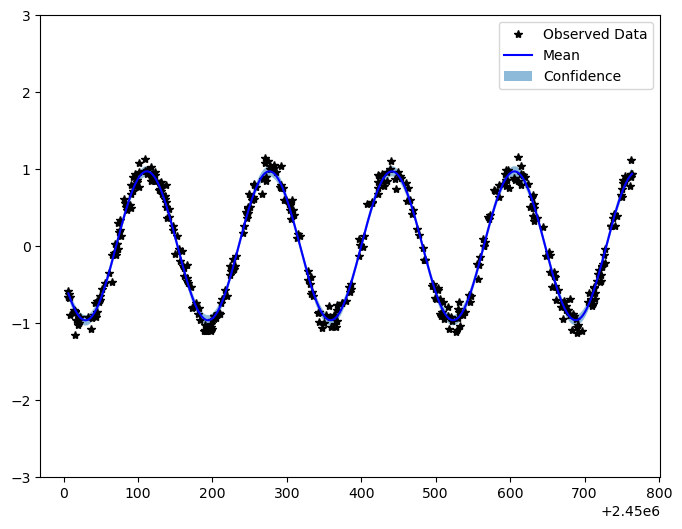

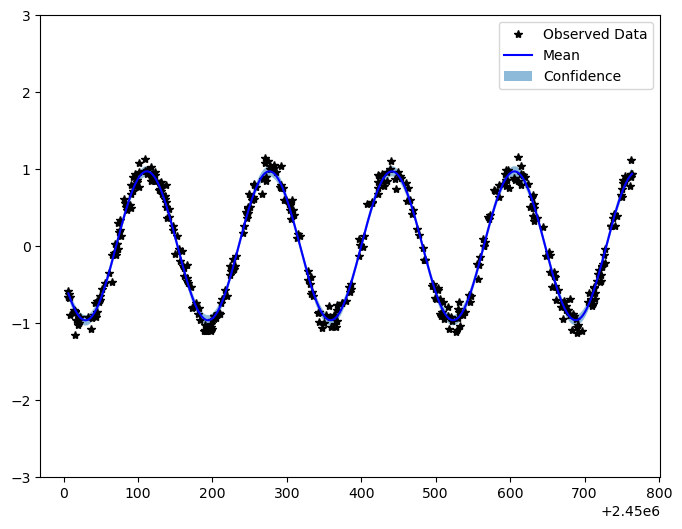

In [8]:
lightcurve_1d.plot(save=False)

or the maximum a-posteriori PSD that pgmuvi has inferred (this can be very slow!)

tensor([1.2404e-06], grad_fn=<MulBackward0>) 0.25 8.0
torch.Size([6448687])
torch.Size([6448687]) torch.Size([1, 1, 1]) torch.Size([1, 1, 1]) torch.Size([1])
Normal(loc: tensor([[[0.0061]]]), scale: tensor([[[6.2018e-06]]]))
torch.Size([1, 6448687, 1])
torch.Size([6448687])


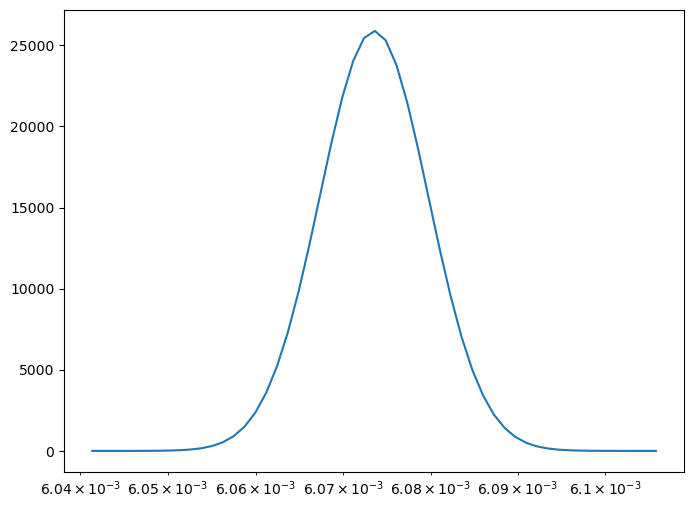

In [9]:
lightcurve_1d.plot_psd()

However, this fit wasn't particularly good! This is because we didn't specify any initial guesses for the hyperparameters, and the default values are not very good for this dataset. We can try again with some better guesses:

In [10]:
lightcurve_1d.print_parameters()
print(period_guess)
guess = {'likelihood.second_noise_covar.noise': torch.Tensor([0.1]),
         'sci_kernel.mixture_means': torch.Tensor([1/period_guess]),}
lightcurve_1d.set_hypers(guess)
lightcurve_1d.print_parameters()

likelihood.second_noise_covar.noise: tensor([0.0007])
mean_module.constant: 0.0040171146392822266
covar_module.mixture_weights: tensor([0.4025])
covar_module.mixture_means: tensor([[[0.0061]]])
covar_module.mixture_scales: tensor([[[6.2018e-06]]])
208.43243643790515
likelihood.second_noise_covar.noise: tensor([0.1000])
mean_module.constant: 0.0040171146392822266
covar_module.mixture_weights: tensor([0.4025])
covar_module.mixture_means: tensor([[[0.0048]]])
covar_module.mixture_scales: tensor([[[6.2018e-06]]])


We printed the parameters before and after setting them to see how they have changed. As we can see, they were updated as instructed. Now we can try to fit again:

In [11]:

new_fit = lightcurve_1d.fit(training_iter=3000, miniter=3000)
lightcurve_1d.print_results()
lightcurve_1d.print_periods()

likelihood.second_noise_covar.noise: tensor([0.1000])
mean_module.constant: 0.0040171146392822266
covar_module.mixture_weights: tensor([0.4025])
covar_module.mixture_means: tensor([[[0.0048]]])
covar_module.mixture_scales: tensor([[[6.2018e-06]]])


100%|██████████| 3000/3000 [00:31<00:00, 95.25it/s] 

loss: [-0.38250878]
delta_loss: [0.001378]
likelihood.second_noise_covar.noise: tensor([0.0008])
mean_module.constant: tensor([0.0086])
covar_module.mixture_weights: tensor([0.4874])
covar_module.mixture_means: tensor([0.0061])
covar_module.mixture_scales: tensor([2.2201e-06])
Period 0: [164.3615] weight: 0.4874323606491089


This results in a much better fit, as you can see:

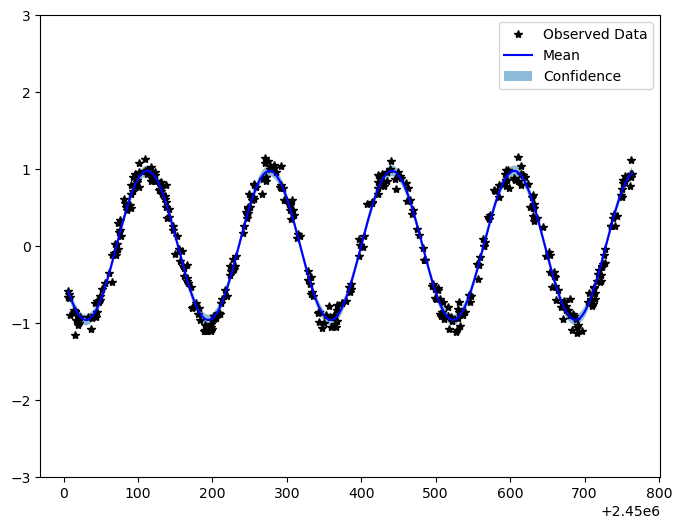

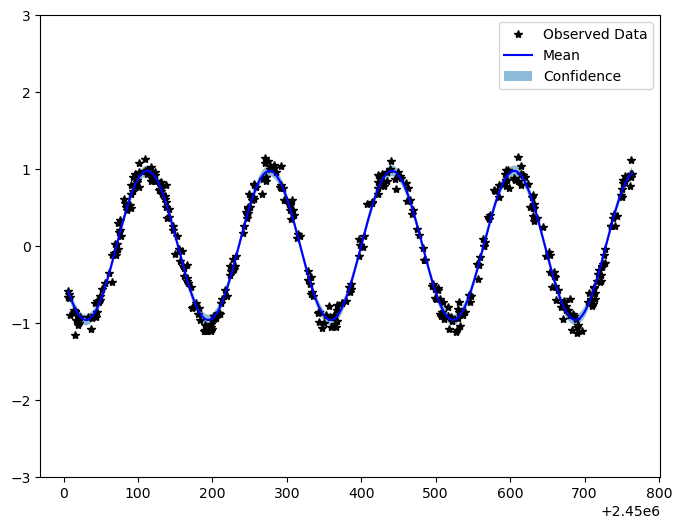

In [12]:
lightcurve_1d.plot(save=False)

We can look at the new PSD, but again this can take a very long time!

tensor([4.4402e-07], grad_fn=<MulBackward0>) 0.25 8.0
torch.Size([18014418])
torch.Size([18014418]) torch.Size([1, 1, 1]) torch.Size([1, 1, 1]) torch.Size([1])
Normal(loc: tensor([[[0.0061]]]), scale: tensor([[[2.2201e-06]]]))
torch.Size([1, 18014418, 1])
torch.Size([18014418])


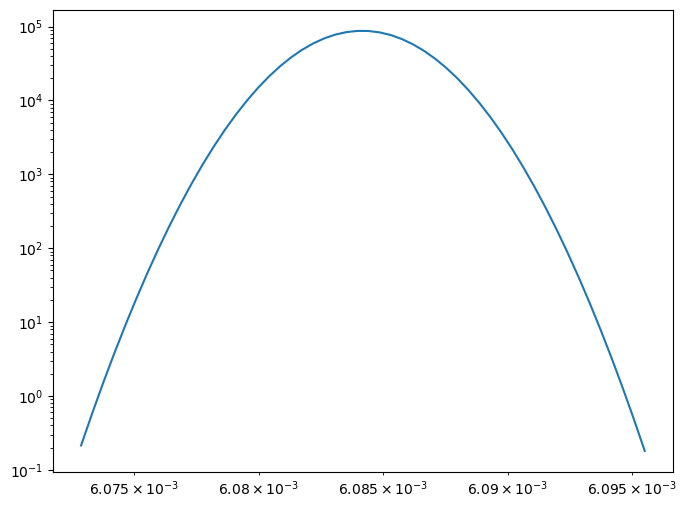

In [13]:
lightcurve_1d.plot_psd(log=(True, True), truncate_psd=True, debug=True)

We can also look at the periods that came out of it:

In [14]:
lightcurve_1d.get_periods()

([array([164.3615], dtype=float32)],
 [tensor(0.4874, grad_fn=<SelectBackward0>)],
 [array([71688.92], dtype=float32)])

And look at the frequency that we used as our guess of the period:

In [15]:
1/period_guess

0.004797717750125296

Now we will take a look at another slightly more advanced topic - setting constraints on the parameters. 
`pgmuvi` tries to make this easy for you, by providing a convenient method `lightcurve1d.set_constraint()`. 
However, there are a few caveats in using it.

Adjusting the constraints on the parameters will not change the values of the internal representation that `gpytorch` uses for the parameters. 
*This will lead to the seemingly odd behaviour that updating the constraints will change the reported values of the parameters!*
This is because `gpytorch` works with an internal representation of the parameters in an unconstrained space, and the constraints are really a transformation from the unconstrained space to a constrained space.
This is done because the unconstrained space is easier to optimise in, and the constraints are applied to transform them to values that are meaningful for the model.
As a result, if you want to update the constraints, **you must set the values of the parameters again afterwards!**
Perhaps even more importantly, if you are updating constraints after performing a fit (as we are here) and want to keep the final state of the parameters, you should save the final state of the parameters, update the constraints, and then set the parameters to the saved values. 
To demonstrate this, we will go through a few of the examples of this here.

In [16]:
# first, let's save the final values of the parameters
pars = lightcurve_1d.get_parameters()
print(pars)

{'likelihood.second_noise_covar.noise': tensor([0.0008]), 'mean_module.constant': tensor(0.0086), 'covar_module.mixture_weights': tensor([0.4874]), 'covar_module.mixture_means': tensor([[[0.0061]]]), 'covar_module.mixture_scales': tensor([[[2.2201e-06]]])}


Now we can set some constraints on the parameters. 
If you're running this yourself, remember to check that the ranges of the constraints include the values of the parameters that were found in the fit!
Otherwise you will get an error when you try to set the parameters to the values found in the fit.

In [17]:
# now, let's update some constraints!
const_dict = {'likelihood.second_noise_covar.noise': gpytorch.constraints.Interval(0.001, 0.15),
              'mean_module.constant': gpytorch.constraints.Interval(-0.1, 0.1),
              'covar_module.mixture_means': gpytorch.constraints.Interval(1/1000., 1/10.),
              'covar_module.mixture_scales': gpytorch.constraints.Interval(1e-6, 0.2),
}
lightcurve_1d.set_constraint(const_dict, debug=True)

Now we've updated the constraints, let's see what has happened to the parameters:

In [18]:
lightcurve_1d.print_parameters()

likelihood.second_noise_covar.noise: tensor([0.0008])
mean_module.constant: 0.008574962615966797
covar_module.mixture_weights: tensor([0.4874])
covar_module.mixture_means: tensor([[[0.0061]]])
covar_module.mixture_scales: tensor([[[2.2201e-06]]])


We can see these are different to those we found above. Let's see what happens if we set the parameters to the values we found above:

In [19]:
lightcurve_1d.set_hypers(pars, debug=True)
lightcurve_1d.print_parameters()

Now they should be back to normal! Let's see what happens if we try to fit again:

In [20]:
fit = lightcurve_1d.fit(training_iter=3000, miniter=3000)
lightcurve_1d.print_results()

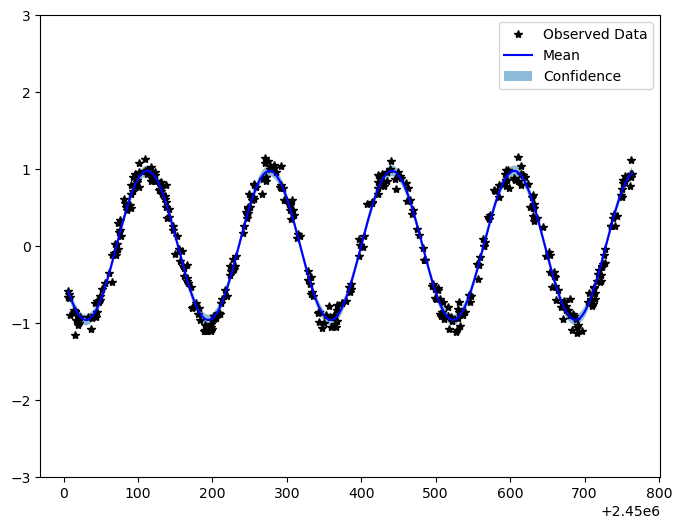

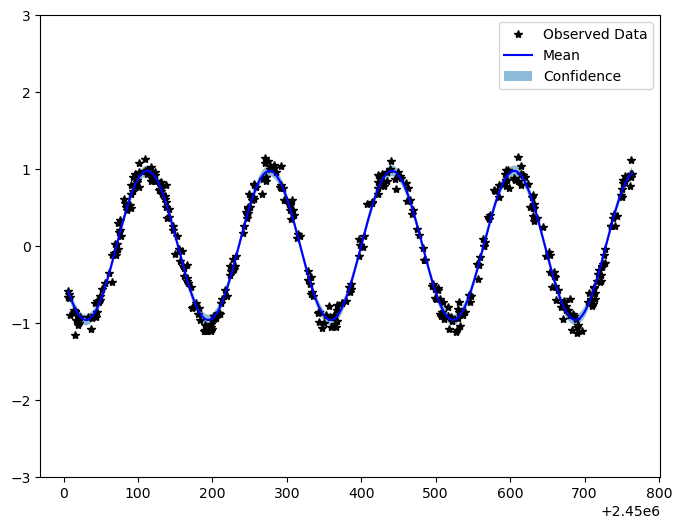

In [21]:
lightcurve_1d.plot()

In [22]:
lightcurve_1d.get_periods()

([array([164.3615], dtype=float32)],
 [tensor(0.4874, grad_fn=<SelectBackward0>)],
 [array([71688.92], dtype=float32)])

You can see that the best-fit period has changed slightly. This is because the constraints we set are not exactly the same as the ones we used in the fit, so the optimiser is not able to find exactly the same solution. However, it is very close, and the fit is still very good.

This is the end of this example. You can find more information in the other example notebooks, for example on how to use MCMC to sample the posterior distribution of the parameters, or how to fit multi-wavelength lightcurves.